# HOTVis: Implementation

## To Do
- Algo testen
- Code überarbeiten (schöner machen, kommentieren etc)
- gucken, an welchen Stellen mans beschleunigen kann

## Imports

In [70]:
import torch
import torch_geometric

import pathpyG as pp

## Übergabeparameter

In [71]:

# nur hier zum testen
tedges = [('a', 'b', 1),('a', 'b', 2), ('b', 'a', 3), ('b', 'c', 3), ('d', 'c', 4), ('a', 'b', 4), ('c', 'b', 4),
              ('c', 'd', 5), ('b', 'a', 5), ('c', 'b', 6)]

graph = pp.TemporalGraph.from_edge_list(tedges)
K = 3
N = 1
delta = 1
alpha = [1, 1, 1]

# optional

force = 1
positions = torch.rand((graph.N, 2))
seed = 0

## Initialisierung

In [72]:
A = torch.zeros((graph.N, graph.N))

## Erste Schleife

Vektorisierung:

Wir benötigen folgende Informationen: Für die Kante $((v_0, ..., v_{k-1}), (v_1,...,v_k))$ eines Higher Order Graphen müssen wir für unseren Algorithmus die Knoten $v_0$ und $v_k$ herausfinden. Bis auf die Benennung der Knoten gibt es keine Datenstruktur wie z.B. eine Adjazenzmatrix in dem Higher Order Graphen, die diese Information direkt oder indirekt beinhaltet. Dadurch müssen wir die Bennenung jeder einzelnen Kante angucken und somit über alle einzelnen Kanten iterieren .

In [73]:
mo_model = pp.MultiOrderModel.from_temporal_graph(graph, delta=delta, max_order=K)
# iterate over higher orders
for i in range(K):
    ho_graph = mo_model.layers[i+1]
    # iterate over edges of higher order graph
    for edge in ho_graph.edges:
        # get start and end node of path of lenth k
        node_start = edge[0]
        node_end = edge[1]
        # in case of higher orders than 1 we need to get the first node of the temporal graph
        #    in the node of the higher order graph
        if(i > 0):
            node_start = edge[0][0]
            node_end = edge[1][0]
        # get indices of the nodes
        index_node_start = graph.mapping.to_idx(node_start)
        index_node_end = graph.mapping.to_idx(node_end)
        # add to A
        A[index_node_start, index_node_end] += alpha[i] * ho_graph['edge_weight', edge[0], edge[1]]
    
print(A)

100%|██████████| 6/6 [00:00<00:00, 108.67it/s]

tensor([[0., 8., 0., 0.],
        [4., 0., 3., 0.],
        [0., 3., 0., 1.],
        [0., 0., 2., 0.]])


## Zweite Schleife

In [74]:
# the initial "temperature"  is about .1 of domain area (=1x1)
# this is the largest step allowed in the dynamics.
t = 0.1  #max(max(layout.T[0]) - min(layout.T[0]), max(layout.T[1]) - min(layout.T[1])) * 0.1
# simple cooling scheme.
# linearly step down by dt on each iteration so last iteration is size dt.
dt = t / float(N + 1)

# displacement = theta
# delta = delta
# distance = |delta|
# force = k

# every nodes "movement" or displacement gets describet by an tuple (x, y) 
displacement = torch.zeros((graph.N, 2))
for iteration in range(N):
    # reset displacement
    displacement *= 0
    # loop over rows
    for i in range(A.shape[0]):
        # difference between this row's node position and all others
        delta = positions[i] - positions
        # distance between points
        distance = torch.sqrt((delta**2).sum(dim=1))
        # enforce minimum distance of 0.01
        distance = torch.where(distance < 0.01, 0.01, distance)
        displacement[i] += (delta/distance.view(-1,1) * (A[i] * distance**2 / force -  force**2 / distance).view(-1,1)).sum(dim=0)
    # update positions
    length = torch.sqrt((displacement**2).sum(dim=1))
    length = torch.where(length < 0.01, 0.1, length)
    delta_layout = (displacement * t / length.view(-1,1))
    positions += delta_layout
    # cool temperature
    t -= dt

## Plot

a
b
c
d
{'a': [0.8181838393211365, 0.2768118381500244], 'b': [0.9137176871299744, 0.7403125166893005], 'c': [0.10982353240251541, 0.6995649337768555], 'd': [0.7447509169578552, 0.849521815776825]}


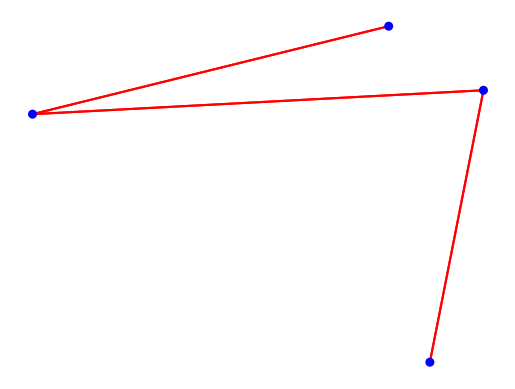

In [77]:
layout = {}
for node in graph.nodes:
    print(node)
    layout[node] = positions[graph.mapping.to_idx(node)].tolist()
print(layout)    
pp.plot(mo_model.layers[1], backend='matplotlib', layout=layout)